In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, RandomizedSearchCV

# import graphviz
# from sklearn.tree import export_graphviz
import time

import xgboost

In [7]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [8]:
# data_prep 에서 train/test split한 pivot table

train_scaled = pd.read_csv("./train_scaled.csv",index_col=0)
test_scaled = pd.read_csv("./test_scaled.csv",index_col=0)

train = pd.read_csv("./train_orig.csv",index_col=0)
test = pd.read_csv("./test_orig.csv",index_col=0)

In [9]:
city_info = ['date_label','geo_label_city']
features_list = []

target_list = ['Cancer | All Cancer Deaths']

# 결측치가 너무 많아/불균형해 제외된 column
avoid_list = ['Substance Use | Teen Smoking',
 'Diabetes and Obesity | Teen Obesity',
 'Substance Use | Teen Alcohol',
 'Physical Activity | Teen Computer Time',
 'Physical Activity | Teen Physical Activity',
 'Substance Use | Teen Marijuana',
 'Physical Activity | Teen TV Time',
 'Dietary Quality | Teen Soda',
 'Mental Health | Electronic Bullying',
 'Mental Health | School Bullying',
 'Mental Health | Teen Mental Distress',
 'Mental Health | Teen Suicidal Ideation',
 'Physical Activity | Teen Physical Inactivity',
 'Respiratory Disease | Teen Asthma',
 'School Violence | Fighting in School',
 'School Violence | Weapons in School',
 'Birth Control | Teen Birth Control',
 'Dietary Quality | Teen Breakfast',
 'Physical Activity | Teen Physical Education',
 'Respiratory Infection | COVID-19 Deaths',
 'Respiratory Infection | COVID-19 Vaccination, Adults',
 'Respiratory Infection | COVID-19 Vaccination, Seniors',
 'Births | Prenatal Care',
 'Crime Incidents | Violent Crime',
 'Lead Poisoning | Child Lead Levels 10+ mcg/dL',
 'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
 'Lead Poisoning | Child Lead Testing']

# 일부 target 따라 너무 비슷한 값(ex) All Cancer를 예측할 때 세분화된 Cancer 사망자)
targetspecific_list = ['Cancer | Breast Cancer Deaths', 'Cancer | Colorectal Cancer Deaths','Cancer | Lung Cancer Deaths','Cancer | Prostate Cancer Deaths', 'Deaths | Deaths from All Causes']

# 두가지를 합쳐서 제외해야할 항목 결정
avoid_list += targetspecific_list

x_train = train_scaled.loc[:,~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_list) | train_scaled.columns.isin(city_info))]#features_list]
y_train = train[target_list]

x_test = test_scaled.loc[:,~(test_scaled.columns.isin(avoid_list) | test_scaled.columns.isin(target_list) | test_scaled.columns.isin(city_info))]#features_list]
y_test = test[target_list]

In [10]:
cities_xgb = xgboost.XGBRegressor(booster = "gbtree", 
                         learning_rate = 0.05, 
                         max_depth = 5,
                         n_estimators = 300)

cities_xgb.fit(x_train,y_train.values.ravel())

cities_pred_train = cities_xgb.predict(x_train)
cities_pred_test = cities_xgb.predict(x_test)

print('train mse: ' ,metrics.mean_squared_error(cities_pred_train,y_train))
print('test mse: ' ,metrics.mean_squared_error(cities_pred_test,y_test))

train mse:  0.05347700406738481
test mse:  368.6859799062848


<Axes: >

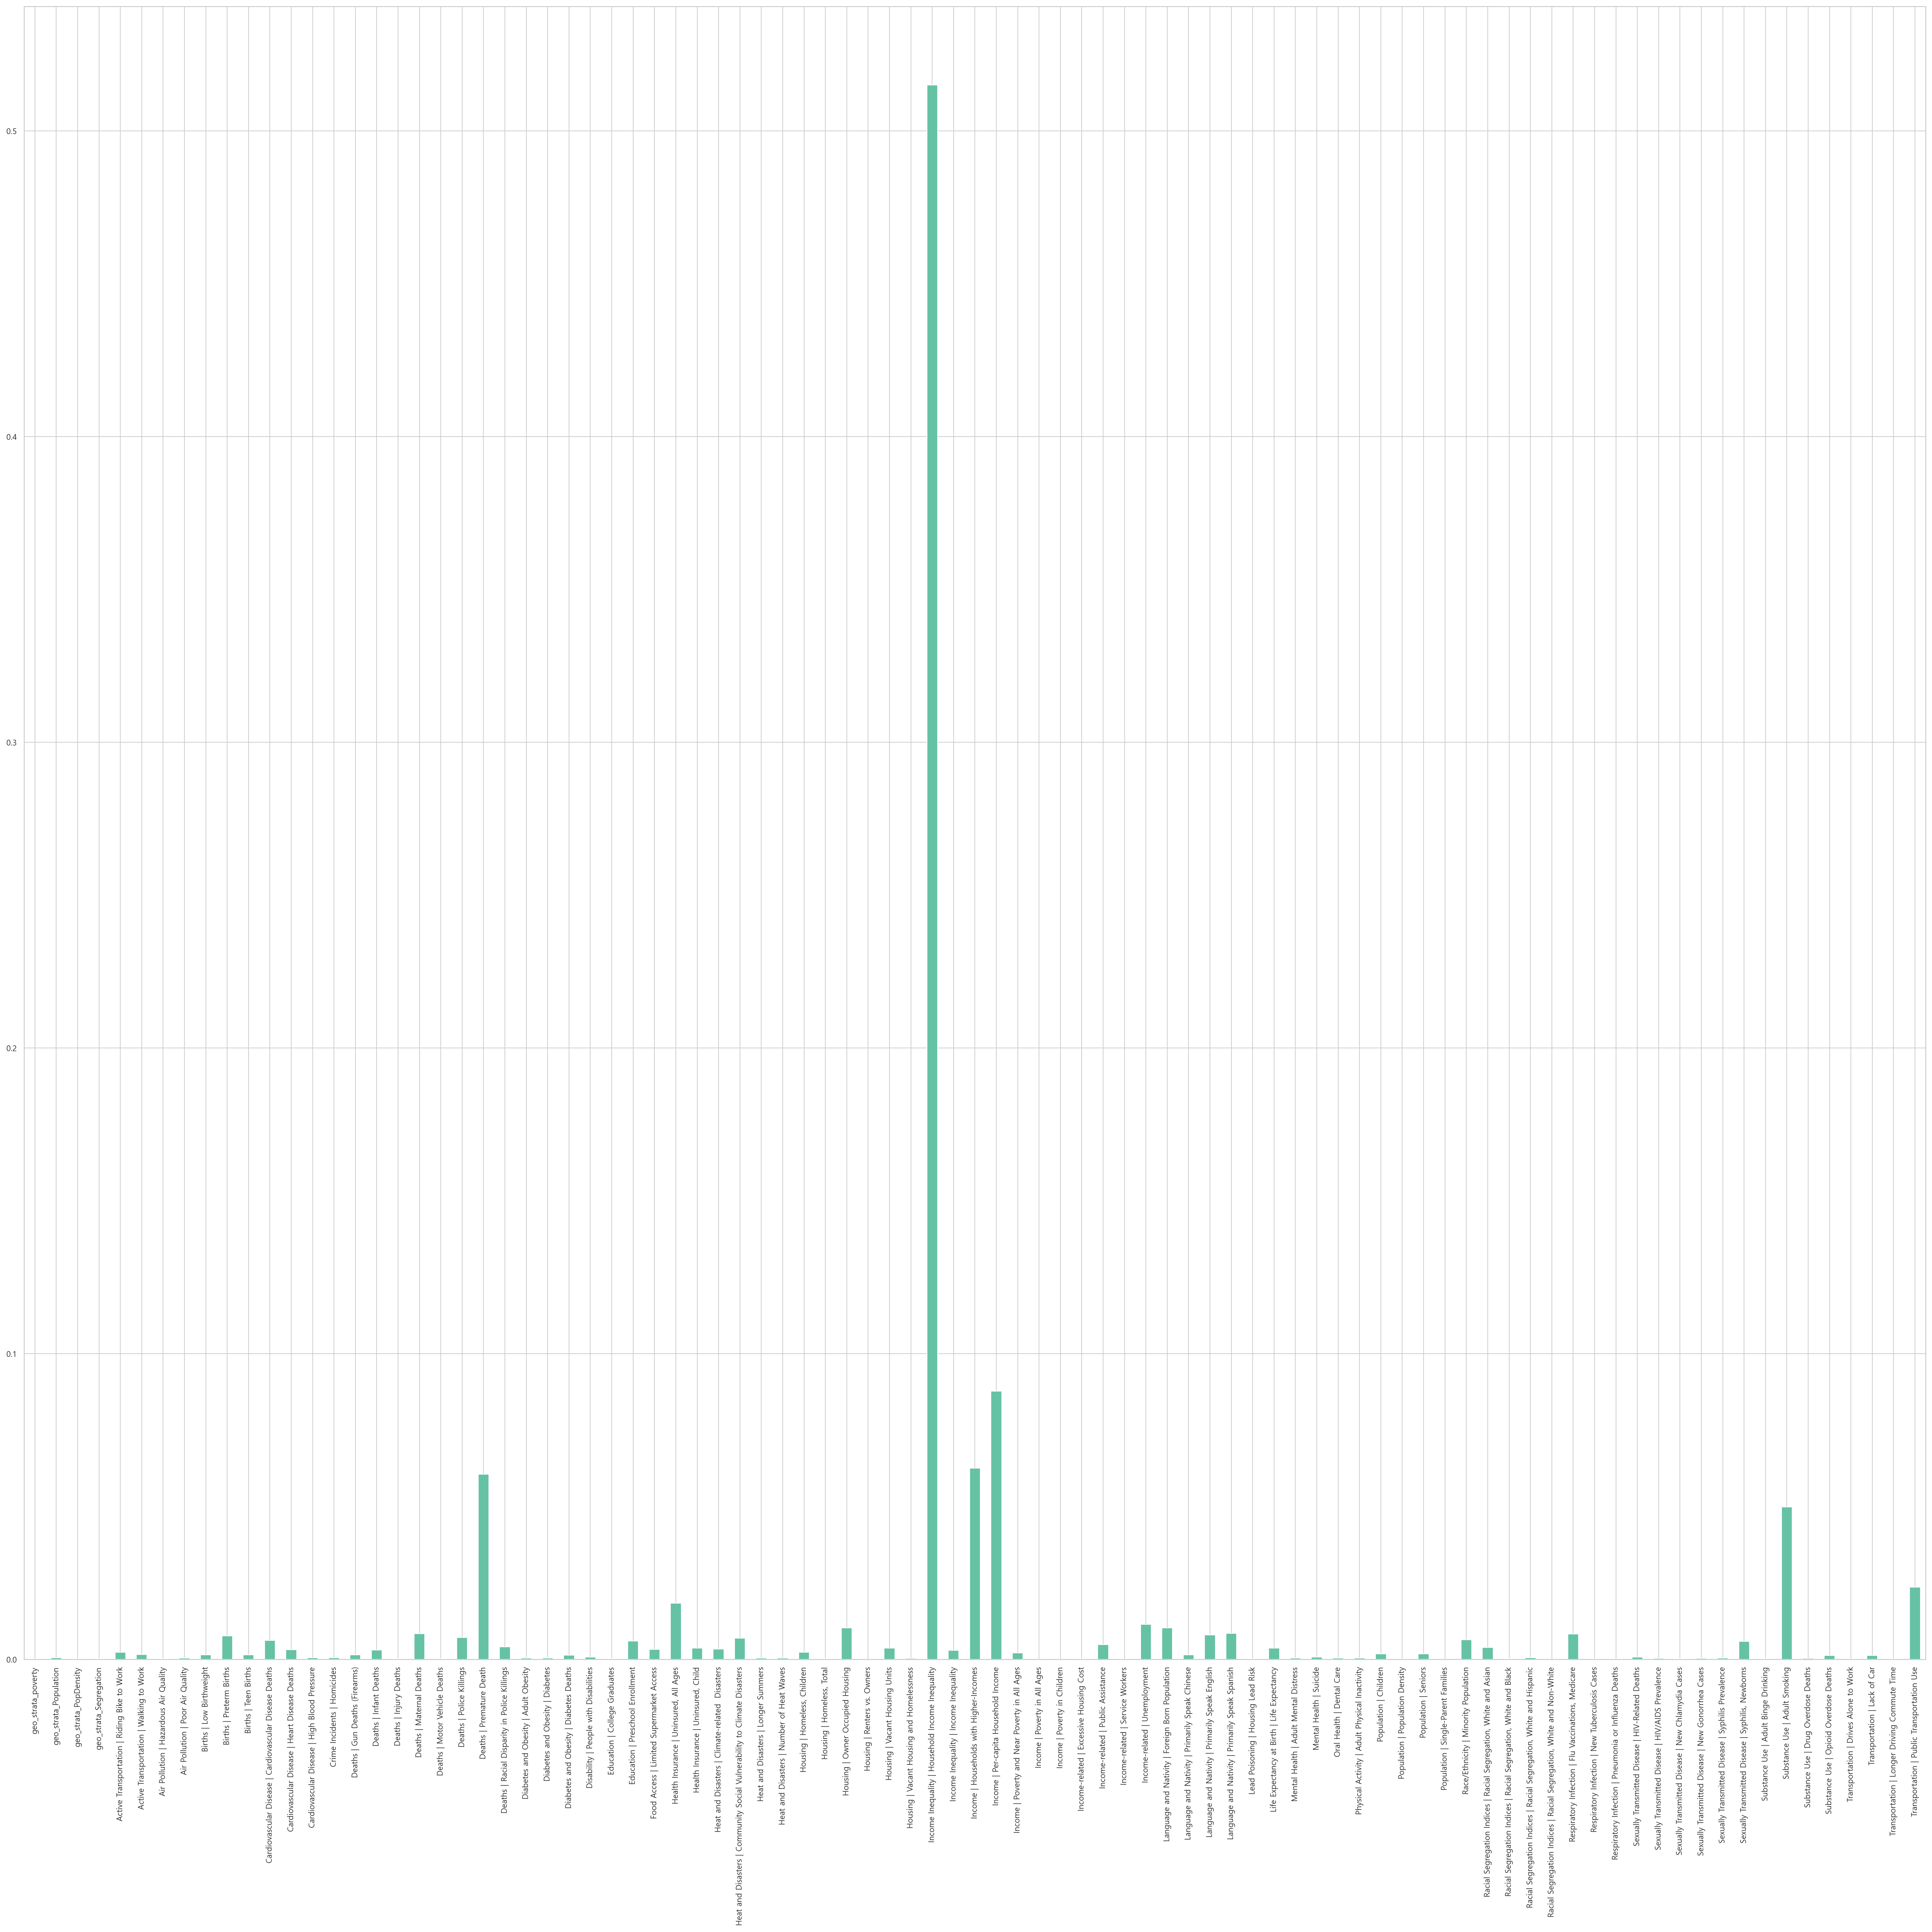

In [12]:
#feature importance 계산
importance = cities_xgb.feature_importances_

xgb_importance = pd.Series(importance, index=x_train.columns)

fig ,ax = plt.subplots(figsize=(30,30))
xgb_importance.plot.bar(ax=ax)

In [14]:
def threshold(p):
    return np.quantile(xgb_importance,p).item()

In [15]:
df_importance = xgb_importance.to_frame()

#95%
display(df_importance[df_importance[0] > threshold(0.95)])
#90%
display(df_importance[df_importance[0] > threshold(0.9)])
#10%
display(df_importance[df_importance[0] < threshold(0.1)])
#5%
display(df_importance[df_importance[0] < threshold(0.05)])

,0
Deaths | Premature Death,0.060507
Income Inequality | Household Income Inequality,0.515040
Income | Households with Higher-Incomes,0.062537
Income | Per-capita Household Income,0.087681
Substance Use | Adult Smoking,0.049765


,0
Deaths | Premature Death,0.060507
"Health Insurance | Uninsured, All Ages",0.018373
Housing | Owner Occupied Housing,0.010266
Income Inequality | Household Income Inequality,0.515040
Income | Households with Higher-Incomes,0.062537
Income | Per-capita Household Income,0.087681
Income-related | Unemployment,0.011402
Substance Use | Adult Smoking,0.049765
Transportation | Public Transportation Use,0.023609


,0
geo_strata_poverty,0.000023
geo_strata_PopDensity,0.000030
Housing | Renters vs. Owners,0.000000
Income | Poverty in Children,0.000016
Income-related | Excessive Housing Cost,0.000038
Income-related | Service Workers,0.000049
Population | Single-Parent Families,0.000000
"Racial Segregation Indices | Racial Segregation, White and Non-White",0.000018
Transportation | Drives Alone to Work,0.000057


,0
geo_strata_poverty,0.000023
Housing | Renters vs. Owners,0.000000
Income | Poverty in Children,0.000016
Population | Single-Parent Families,0.000000
"Racial Segregation Indices | Racial Segregation, White and Non-White",0.000018
